<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/pendulum_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ECE 447: Simple Control of a Pendulum
===

Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington


In [0]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')


<img src="https://raw.githubusercontent.com/christakahashi/ECE447/master/images/pendulum_2.png" width=50%>

Recall the pendulum model

$$
\dot{\left (
\begin{array}{c} 
\theta \\ 
\omega
\end{array} \right )} = 
\left (
\begin{array}{c} 
\omega \\ 
\sin\theta-\omega + u
\end{array} \right )
$$

where $u$ is the torque applied to the pendulum.
Suppose the output is the position $\theta$:

$$
y = \theta
$$

We can linearize this system as follows:

In [27]:
var("theta omega u y")
f = Matrix([omega, sin(theta) + - omega + u])
g = Matrix([theta])
pfpx = f.jacobian(Matrix([theta,omega]))
pfpu = f.jacobian(Matrix([u]))
pgpx = g.jacobian(Matrix([theta,omega]))
pgpu = g.jacobian(Matrix([u]))
A = pfpx.subs(theta,0).subs(omega,0).subs(u,0)
B = pfpu.subs(theta,0).subs(omega,0).subs(u,0)
C = pgpx.subs(theta,0).subs(omega,0).subs(u,0)
D = pgpu.subs(theta,0).subs(omega,0).subs(u,0)
A,B,C,D

⎛⎡0  1 ⎤  ⎡0⎤             ⎞
⎜⎢     ⎥, ⎢ ⎥, [1  0], [0]⎟
⎝⎣1  -1⎦  ⎣1⎦             ⎠

So our linear model is 

$$
\dot x = \begin{pmatrix}
0 & 1 \\
1 & -1
\end{pmatrix} x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$

$$
y = ( 0 \;\;\; 1 ) x
$$

A somewhat simple way to control the pendulum to track a *reference input* r is to just wqrap a feedback loop around the system with a gain $K$.

<img src="https://raw.githubusercontent.com/christakahashi/ECE447/master/images/IO%20BD.png" width=70%>

In this case, we get a new linear system with input $r$ and output $y$. Here, $K$ is a *tunable* design parameter.

We can find the equations for the new system by noting that

$$
u = K(r-y)
$$

then


\begin{align}
\dot x & = A x + B K (r-y) \\
        & = A x + B K r - B K C x \\
        & = ( A - B K C ) x + B K r
\end{align}


so our new system has

$$
\dot x = \tilde{A} x + \tilde{B} r
$$

with 

$$
\tilde{A} = A - B K C 
$$

and

$$
\tilde{B} = B K
$$

Since we still have $y = \theta$, we still have $y = C x$ as before.

Using `sympy` we can compute these matrices:

In [28]:
var("K")
Anew = A - K*B*C
Bnew = K*B
Anew,Bnew

⎛⎡  0     1 ⎤  ⎡0⎤⎞
⎜⎢          ⎥, ⎢ ⎥⎟
⎝⎣-K + 1  -1⎦  ⎣K⎦⎠

We can can find the eigenvalues of $\tilde{A}$:

In [29]:
lam1,lam2=Anew.eigenvals()
lam1,lam2

⎛    __________        __________    ⎞
⎜  ╲╱ -4⋅K + 5    1  ╲╱ -4⋅K + 5    1⎟
⎜- ──────────── - ─, ──────────── - ─⎟
⎝       2         2       2         2⎠

And plot them as a function of $K$:

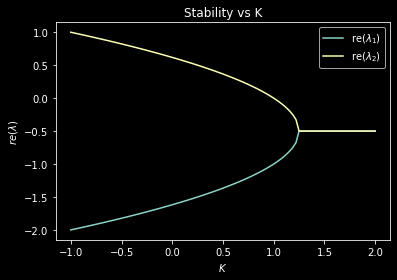

In [30]:
kvals = np.linspace(-1,2,101)
f1=lambdify(K,re(lam1), modules=['numpy'])
f2=lambdify(K,re(lam2), modules=['numpy'])
plt.plot(kvals,f1(kvals), label="$\mathrm{re}(\lambda_1)$")
plt.plot(kvals,f2(kvals), label="$\mathrm{re}(\lambda_2)$")
plt.xlabel("$K$")
plt.ylabel("$re(\lambda)$")
plt.title("Stability vs K")
plt.legend();

In [31]:
lam1.subs(K,1),lam2.subs(K,1)

(-1, 0)

In [32]:
lam1.subs(K,1.1),lam2.subs(K,1.1)

(-0.887298334620742, -0.112701665379258)

In [33]:
lam1.subs(K,5/4),lam2.subs(K,5/4)

(-1/2, -1/2)

In [34]:
lam1.subs(K,2),lam2.subs(K,2)

⎛  1   √3⋅ⅈ    1   √3⋅ⅈ⎞
⎜- ─ - ────, - ─ + ────⎟
⎝  2    2      2    2  ⎠

In [41]:
var("t tau r k")
k = 5
x0=Matrix([0,0])
xnat = exp(Anew.subs(K,k)*t)*x0
xnat

⎡0⎤
⎢ ⎥
⎣0⎦

In [47]:
w = exp(Anew.subs(K,5/4)*(t-tau))*Bnew.subs(K,5/4)*r
xforced = integrate(w,(tau,0,t))
x = xnat + xforced
y = C*x + D*r
display(y)

⎡                           -0.5⋅t⎤
⎣5.0⋅r - (2.5⋅r⋅t + 5.0⋅r)⋅ℯ      ⎦

In [48]:
y

⎡                           -0.5⋅t⎤
⎣5.0⋅r - (2.5⋅r⋅t + 5.0⋅r)⋅ℯ      ⎦

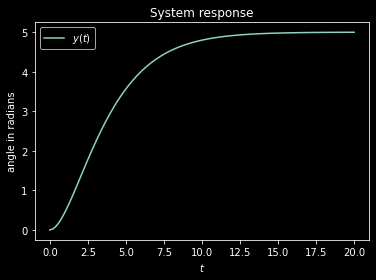

In [49]:
tvals = np.linspace(0,20,100)
f = lambdify(t,y[0].subs(r,1), modules=['numpy'])
plt.figure()   
plt.plot(tvals, f(tvals),label="$y(t)$")
plt.xlabel('$t$')
plt.ylabel('angle in radians')
plt.title("System response")
plt.legend();

Note that an annoying thing that happens is that $r$ gets scaled by $B$, which has a $K$ in it. So typically one scales $r$ with to make it match the desired output size. Thus, we get something more like:

In [50]:
limit(xforced[0],t,oo),limit(xforced[1],t,oo)

(5.0⋅r, 0)

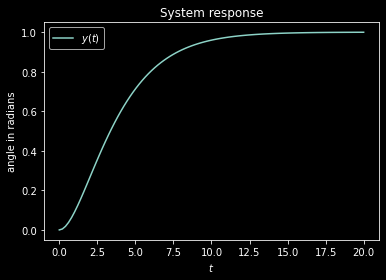

In [51]:
tvals = np.linspace(0,20,100)
f = lambdify(t,y[0].subs(r,1/(K)).subs(K,k), modules=['numpy'])
plt.figure()   
plt.plot(tvals, f(tvals),label="$y(t)$")
plt.xlabel('$t$')
plt.ylabel('angle in radians')
plt.title("System response")
plt.legend();